In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

2D ray-box clip (slab method)
- given (1) a ray described by origin and direction, and (2) the bounding box of a axis-aligned square
- returns if the line (1) hit/not hit the box, and if yes, (2) t0 and t1 parameters
- we can find the ingress/outgress of the points using p_i = o + t_i * d

In [2]:
def ray_box_intersect_2d(o, d, box_min, box_max):
    """Return (hit, t0, t1) where segment inside box is o + t d, t in [t0, t1]."""
    t0, t1 = -np.inf, np.inf
    for k in range(2):
        if abs(d[k]) < 1e-12:
            # parallel to this axis: must be within slab
            if o[k] < box_min[k] or o[k] > box_max[k]:
                return False, 0.0, 0.0
        else:
            inv = 1.0 / d[k]
            t_near = (box_min[k] - o[k]) * inv
            t_far  = (box_max[k] - o[k]) * inv
            if t_near > t_far:
                t_near, t_far = t_far, t_near
            t0 = max(t0, t_near)
            t1 = min(t1, t_far)
            if t0 > t1:
                return False, 0.0, 0.0
    return True, t0, t1

In [3]:
# dummy code
# a line intersect a box or not, and also the points of intersection
o, d, box_min, box_max = (1,2), (1,1), (2,1), (4,4)
hit, t0, t1 = ray_box_intersect_2d(o, d, box_min, box_max)
p0 = o + t0*np.array(d)
p1 = o + t1*np.array(d)
print(f"p0:{p0}, p1:{p1}")

p0:[2. 3.], p1:[3. 4.]


2D DDA with per-cell segment length

In [3]:
def dda_ray_with_lengths(origin, direction, bounds, max_steps=20_000):
    """
    Amanatides & Woo DDA in 2D.
    Returns list of (ix, iy, length) for each grid cell the ray crosses inside 'bounds'.

    bounds: (xmin, xmax, ymin, ymax)  with integer cell indices.
            Cells are [i, i+1) × [j, j+1) for i in [xmin, xmax-1], j in [ymin, ymax-1].
    """
    x0, y0 = map(float, origin)
    dx, dy = map(float, direction)
    xmin, xmax, ymin, ymax = bounds

    # normalize direction
    n = np.hypot(dx, dy)
    if n < 1e-12:
        return []
    dx /= n; dy /= n

    # clip to the grid box in WORLD coords:
    # the box spans from (xmin, ymin) to (xmax, ymax) in world/grid units
    hit, t_enter, t_exit = ray_box_intersect_2d(
        np.array([x0, y0]),
        np.array([dx, dy]),
        np.array([xmin, ymin]),
        np.array([xmax, ymax])
    )
    if not hit or t_exit <= max(t_enter, 0.0):
        return []

    # start at entry point; measure all t relative to entry
    t0 = max(t_enter, 0.0)
    px, py = x0 + t0 * dx, y0 + t0 * dy

    # initial cell (ensure boundary cases put you inside the correct cell)
    ix = int(np.floor(px))
    iy = int(np.floor(py))
    # if exactly on a grid line and moving negative, move to the cell "behind" the line
    eps = 1e-10
    if abs(px - np.floor(px)) < eps and dx < 0: ix -= 1
    if abs(py - np.floor(py)) < eps and dy < 0: iy -= 1

    # step direction
    step_x = 1 if dx > 0 else -1
    step_y = 1 if dy > 0 else -1

    # distance between x/y boundaries in t
    tDeltaX = (1.0 / abs(dx)) if abs(dx) > 0 else np.inf
    tDeltaY = (1.0 / abs(dy)) if abs(dy) > 0 else np.inf

    # distance to the next x/y boundary from the entry point
    if dx > 0:
        next_x_boundary = ix + 1
        tMaxX = (next_x_boundary - px) / dx
    elif dx < 0:
        next_x_boundary = ix     # left boundary of current cell
        tMaxX = (next_x_boundary - px) / dx
    else:
        tMaxX = np.inf

    if dy > 0:
        next_y_boundary = iy + 1
        tMaxY = (next_y_boundary - py) / dy
    elif dy < 0:
        next_y_boundary = iy
        tMaxY = (next_y_boundary - py) / dy
    else:
        tMaxY = np.inf

    cells = []
    t = 0.0                     # param measured from entry
    t_end = (t_exit - t0)       # how long we are inside the box

    for _ in range(max_steps):
        if not (xmin <= ix < xmax and ymin <= iy < ymax):
            break
        # next boundary we will hit (or exit)
        tNext = min(tMaxX, tMaxY, t_end)
        seg_len = tNext - t
        if seg_len <= 0:
            break

        # record current cell and its segment length
        cells.append((ix, iy, seg_len))
        t = tNext
        if t >= t_end - 1e-12:
            break  # we reached the exit

        # step to the neighbor cell and update the boundary time
        if abs(tMaxX - tNext) < 1e-12 and abs(tMaxY - tNext) < 1e-12:
            # crossing both x and y boundary (corner)
            ix += step_x
            iy += step_y
            tMaxX += tDeltaX
            tMaxY += tDeltaY
        elif tMaxX < tMaxY:
            ix += step_x
            tMaxX += tDeltaX
        else:
            iy += step_y
            tMaxY += tDeltaY

    return cells


In [ ]:
# dummy code
origin = (1, 1)
direction = (1, 1)
bounds = (0, 10, 0, 10)
cells = dda_ray_with_lengths(origin, direction, bounds)
cells

[(1, 1, 1.4142135623730951),
 (2, 2, 1.4142135623730951),
 (3, 3, 1.4142135623730954),
 (4, 4, 1.414213562373095),
 (5, 5, 1.414213562373095),
 (6, 6, 1.4142135623730958),
 (7, 7, 1.4142135623730958),
 (8, 8, 1.4142135623730958),
 (9, 9, 1.414213562373094)]

Demo

In [4]:
def demo_plot(origin, direction, bounds, show_length=True, show_ticks=True):
    xmin, xmax, ymin, ymax = bounds
    cells = dda_ray_with_lengths(origin, direction, bounds)

    fig, ax = plt.subplots(figsize=(5,5))
    # draw grid lines
    for x in range(xmin, xmax+1):
        ax.axvline(x, color='lightgray', lw=0.8, zorder=0)
    for y in range(ymin, ymax+1):
        ax.axhline(y, color='lightgray', lw=0.8, zorder=0)

    # shade visited cells with lengths annotated
    for (ix, iy, L) in cells:
        rect = patches.Rectangle((ix, iy), 1, 1, facecolor='cornflowerblue', alpha=0.4, edgecolor='k')
        ax.add_patch(rect)
        if show_length:
            ax.text(ix+0.5, iy+0.5, f"{L:.2f}", ha='center', va='center', fontsize=9)

    # draw the true infinite line; show only across the box
    # compute the clipped endpoints for nice plotting
    o = np.array(origin, dtype=float)
    d = np.array(direction, dtype=float)
    d = d / (np.hypot(d[0], d[1]) + 1e-12)
    hit, t0, t1 = ray_box_intersect_2d(o, d, np.array([xmin, ymin]), np.array([xmax, ymax]))
    if hit:
        p0 = o + max(t0, 0.0)*d
        p1 = o + t1*d
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'r--', lw=1.8, label='True line (clipped)')

    # origin marker
    ax.plot(origin[0], origin[1], 'go', label='Origin')

    # axes / labels
    ax.set_xlim(xmin-1, xmax+1)
    ax.set_ylim(ymin-1, ymax+1)
    ax.set_aspect('equal')
    if show_ticks:
        ax.set_xticks(range(xmin, xmax+1))
        ax.set_yticks(range(ymin, ymax+1))
    ax.set_title("2D DDA Ray Traversal (cells + segment lengths)")
    ax.legend()
    plt.show()

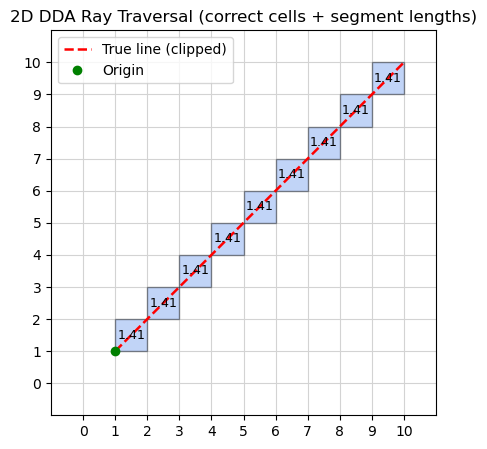

In [ ]:
#demo_plot(origin, direction, bounds)

Object definitions

In [ ]:
# OLD (simple shapes on small grid)
mu1 = 0.03
mu2 = 0.20

square_min = np.array([3.0, 2.0])
square_max = np.array([5.0, 4.0])

rect_min = np.array([7.0, 3.0])
rect_max = np.array([8.0, 7.0])

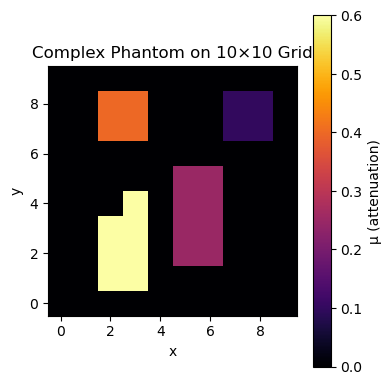

mu_true_vec shape: (100,)


In [155]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# -----------------------------
# Densities
# -----------------------------
mu_bg = 0.0     # background
mu1 = 0.10      # square
mu2 = 0.25      # rectangle
mu3 = 0.40      # circle
mu4 = 0.60      # polygon

# -----------------------------
# Grid bounds (10×10)
# -----------------------------
bounds = 0, 10, 0, 10
grid_nx = bounds[1]
grid_ny = bounds[3]
grid_shape = (grid_nx, grid_ny)
phantom = np.full((grid_nx, grid_ny), mu_bg, dtype=float)

ix = np.arange(grid_nx)
iy = np.arange(grid_ny)

# -----------------------------
# Square (top-right corner)
# -----------------------------
square_min = np.array([7.0, 7.0])
square_max = np.array([9.0, 9.0])
for x in ix:
    for y in iy:
        if square_min[0] <= x < square_max[0] and square_min[1] <= y < square_max[1]:
            phantom[x, y] = mu1

# -----------------------------
# Rectangle (middle-right)
# -----------------------------
rect_min = np.array([5.0, 2.0])
rect_max = np.array([7.0, 6.0])
for x in ix:
    for y in iy:
        if rect_min[0] <= x < rect_max[0] and rect_min[1] <= y < rect_max[1]:
            phantom[x, y] = mu2

# -----------------------------
# Circle (upper-left)
# -----------------------------
cx, cy, r = 2.5, 7.5, 1.5
Y, X = np.meshgrid(iy, ix)
mask_circle = (X - cx) ** 2 + (Y - cy) ** 2 <= r ** 2
phantom[mask_circle] = mu3

# -----------------------------
# Polygon (bottom-left)
# -----------------------------
poly_points = np.array([
    [1,1], [1,3], [3,4], [4,3], [4,1], [2,0.5]
])
path = Path(poly_points)
Xf, Yf = np.meshgrid(np.arange(grid_nx), np.arange(grid_ny), indexing='ij')
coords = np.vstack((Xf.ravel(), Yf.ravel())).T
poly_mask = path.contains_points(coords).reshape((grid_nx, grid_ny))
phantom[poly_mask] = mu4

# -----------------------------
# Visualization
# -----------------------------
plt.figure(figsize=(4,4))
plt.imshow(phantom.T, origin='lower', cmap='inferno')
plt.title("Complex Phantom on 10×10 Grid")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label="μ (attenuation)")
plt.tight_layout()
plt.show()

# -----------------------------
# Flatten phantom for tomography
# -----------------------------
mu_true_vec = phantom.flatten()  # transpose for consistency with A
print("mu_true_vec shape:", mu_true_vec.shape)


Define the rays

In [156]:
bounds

(0, 10, 0, 10)

In [ ]:
import numpy as np

N_view = 32 # number of rays per view
views = 3
N = N_view * views 
domain_size = max(bounds[1]-bounds[0], bounds[1]-bounds[0])

# Horizontal rays (left - right)
ys = np.linspace(bounds[0]+1.0, bounds[1]-1.0, N_view)
rays_o_h = np.array([[0.0, y] for y in ys])
rays_d_h = np.tile(np.array([1.0, 0.0]), (N_view, 1))

# Vertical rays (bottom - top)
xs = np.linspace(bounds[2]+1.0, bounds[3]+1.0, N_view)
rays_o_v = np.array([[x, 0.0] for x in xs])
rays_d_v = np.tile(np.array([0.0, 1.0]), (N_view, 1))

# 45° rays (bottom-left - top-right)
offsets = np.linspace(0.0, domain_size // 2, N_view // 2)
rays_o_d_v = np.array([[0.0, off] for off in sorted(offsets, reverse=True)])
rays_o_d_h = np.array([[off, 0.0] for off in offsets])
rays_o_d = np.concatenate((rays_o_d_v, rays_o_d_h), axis=0)
rays_d_d = np.tile(np.array([1.0, 1.0]) / np.sqrt(2), (N_view, 1))  # normalized dir

# combine the views
rays_o = np.vstack((rays_o_h, rays_o_v, rays_o_d))
rays_d = np.vstack((rays_d_h, rays_d_v, rays_d_d))

print("rays_o shape:", rays_o.shape)
print("rays_d shape:", rays_d.shape)


rays_o shape: (64, 2)
rays_d shape: (64, 2)


Compute matrix A

In [172]:
N = len(rays_o)
M = grid_nx * grid_ny

A = np.zeros((N, M), dtype=float)

for i in range(N):
    o = rays_o[i]
    d = rays_d[i]
    cells = dda_ray_with_lengths(o, d, bounds)

    for (ix, iy, L) in cells:
        if 0 <= ix < grid_nx and 0 <= iy < grid_ny:
            j = ix * grid_ny + iy
            A[i, j] = L

print(f"Matrix A computed with shape {A.shape}")
print(f"({A.shape[0]} rays, {A.shape[1]} cells)")
print(f"Grid bounds: x ({bounds[0]}-{bounds[1]}), y ({bounds[2]}-{bounds[3]})")


Matrix A computed with shape (64, 100)
(64 rays, 100 cells)
Grid bounds: x (0-10), y (0-10)


Compute attenuation for every ray.

In [173]:
# forward projection
b_i = A @ mu_true_vec
b_i.shape

(64,)

In [174]:
err = np.linalg.norm(A @ mu_true_vec - b_i)
rel = err / np.linalg.norm(b_i)
print(f"Forward model mismatch: {err:.3e} (relative {rel:.2%})")


Forward model mismatch: 0.000e+00 (relative 0.00%)


In [70]:
# OLD (simple shapes on a small grid)
b = np.zeros((N, 1))
for i in range(N):
    o = rays_o[i]
    d = rays_d[i]
    total = 0.0
    
    # Intersect with square
    hit, t0, t1 = ray_box_intersect_2d(o, d, square_min, square_max)
    if hit:
        L = (t1 - t0) * np.linalg.norm(d)
        total += mu1 * L
    
    # Intersect with rectangle
    hit, t0, t1 = ray_box_intersect_2d(o, d, rect_min, rect_max)
    if hit:
        L = (t1 - t0) * np.linalg.norm(d)
        total += mu2 * L

    b[i, 0] = total

I_f = np.exp(-b)
I_s = 1.0
b_i = np.log(I_s / I_f)  # same as b

b_i.shape

(36, 1)

Sanity check (A, mu, b)

In [175]:
print('A\t', A.shape)
print('mu\t', mu_true_vec.shape)
print('b_i\t', b_i.shape)


A	 (64, 100)
mu	 (100,)
b_i	 (64,)


In [ ]:
# slice attenuations per view
b_h = b_i[0:N_view]                    # horizontal
b_v = b_i[N_view:2*N_view]             # vertical
b_d = b_i[2*N_view:3*N_view]           # 45° diagonal

print("Ray attentuations (horizontal, vertical, diagonal)")
print(f"b_h.shape: {b_h.shape}")
print(f"b_v.shape: {b_v.shape}")
print(f"b_d.shape: {b_d.shape}")

Ray attentuations (horizontal, vertical, diagonal)
b_h.shape: (32,)
b_v.shape: (32,)


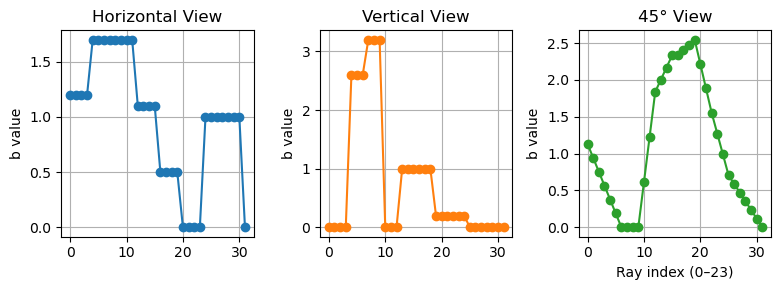

In [163]:
def show_attenuations(b_h, b_v, b_d, N_view):
    '''
        b_h: horizontal attenuations
        b_v: vertical attenuations
        b_d: diagonal attenuations
        N_view: number of attenuations per view
    '''
    rays_idx = np.arange(N_view)

    _, axes = plt.subplots(1, 3, figsize=(8,3), sharex=True)

    axes[0].plot(rays_idx, b_h, '-o', color='tab:blue')
    axes[0].set_title("Horizontal View")
    axes[0].set_ylabel("b value")
    axes[0].grid()

    axes[1].plot(rays_idx, b_v, '-o', color='tab:orange')
    axes[1].set_title("Vertical View")
    axes[1].set_ylabel("b value")
    axes[1].grid()

    axes[2].plot(rays_idx, b_d, '-o', color='tab:green')
    axes[2].set_title("45° View")
    axes[2].set_xlabel("Ray index (0–23)")
    axes[2].set_ylabel("b value")
    axes[2].grid()

    plt.tight_layout()
    plt.show()

show_attenuations(b_h, b_v, b_d, N_view)

Visualization per view (horizontal, vertical, diagonal)

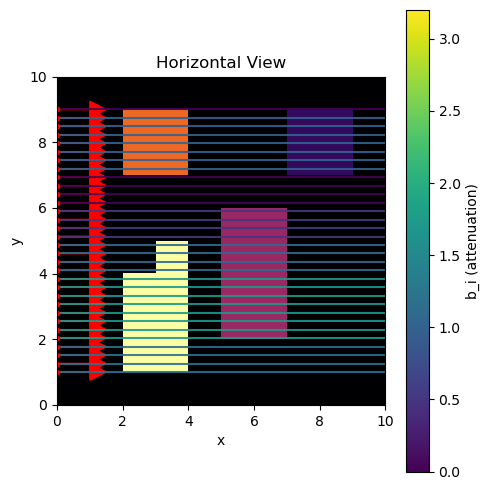

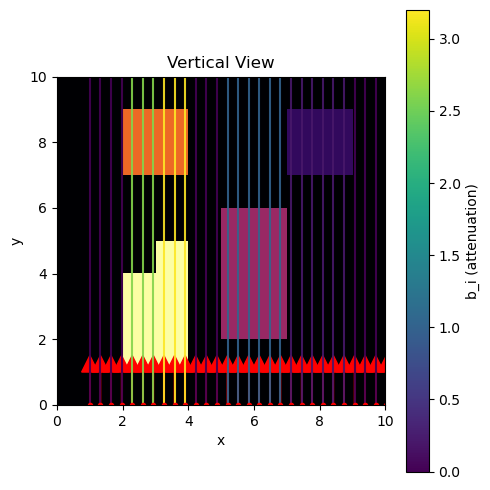

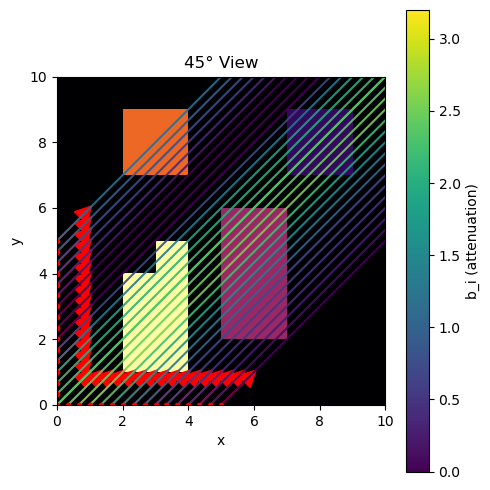

In [164]:
import matplotlib.pyplot as plt
import numpy as np

def plot_view(rays_o, rays_d, b_vals, title, phantom, b_all):
    """
    Visualize a view with the phantom grid and colored rays.
    phantom : 2D numpy array of μ values (phantom[x,y])
    b_all   : full b_i array, used for color normalization
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect('equal')
    ax.set_xlim(0, phantom.shape[0])
    ax.set_ylim(0, phantom.shape[1])
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(False)

    # --- Draw the phantom grid as an image ---
    ax.imshow(phantom.T, origin='lower', cmap='inferno',
              extent=[0, phantom.shape[0], 0, phantom.shape[1]])

    # --- Draw rays with color according to attenuation ---
    strech_ray = 2.0
    vmax = np.max(b_all)
    vmin = np.min(b_all)
    for i in range(len(rays_o)):
        o = rays_o[i]
        d = rays_d[i]
        color = plt.cm.viridis((b_vals[i] - vmin) / (vmax - vmin) if vmax > vmin else 0)
        ax.plot([o[0], o[0] + phantom.shape[0] * d[0] * strech_ray],
                [o[1], o[1] + phantom.shape[1] * d[1] * strech_ray],
                color=color, lw=1.5, alpha=0.9)
        ax.plot(o[0], o[1], 'ro', markersize=3)
        ax.arrow(o[0], o[1], d[0], d[1],
                 head_width=0.5, head_length=0.5, fc='r', ec='r')

    # --- Colorbar for attenuation ---
    sm = plt.cm.ScalarMappable(cmap='viridis',
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('b_i (attenuation)')

    plt.tight_layout()
    plt.show()

plot_view(rays_o_h, rays_d_h, b_h, "Horizontal View", phantom, b_i)
plot_view(rays_o_v, rays_d_v, b_v, "Vertical View", phantom, b_i)
plot_view(rays_o_d, rays_d_d, b_d, "45° View", phantom, b_i)


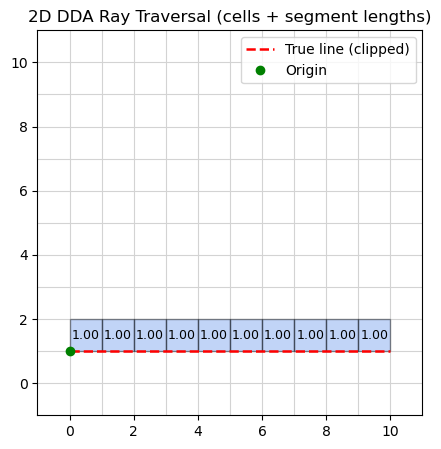

In [165]:
i = np.random.randint(len(rays_o))
demo_plot(rays_o[i], rays_d[i], bounds, show_length=True, show_ticks=False)


Reconstructing with ART

In [166]:
from tqdm import tqdm

def art_nn(A, b, num_epochs=50, relaxation=0.8, shuffle=True, clip_min=0.0):
    A = np.asarray(A, float)
    b = np.asarray(b, float).flatten()
    N, M = A.shape

    mu = np.zeros(M, dtype=float)
    row_norm2 = np.sum(A * A, axis=1) + 1e-12
    row_idx = np.arange(N)
    rmse_list = []

    for epoch in tqdm(range(num_epochs)):
        if shuffle:
            np.random.shuffle(row_idx)
        for i in row_idx:
            Ai = A[i]
            residual = b[i] - np.dot(Ai, mu)
            mu += relaxation * (residual / row_norm2[i]) * Ai
            if clip_min is not None:
                mu = np.clip(mu, clip_min, None)

        pred = A.dot(mu)
        resid = b - pred
        resid = resid[np.isfinite(resid)]
        rmse = np.sqrt(np.mean(resid ** 2)) if len(resid) > 0 else np.nan
        rmse_list.append(rmse)

        # Optional stability guard
        if not np.isfinite(rmse):
            print(f"NaN detected at epoch {epoch}, stopping.")
            break

    return mu, rmse_list


In [167]:
%%time
mu_vec, rmse_list = art_nn(A, b_i, num_epochs=1_000, relaxation=0.5)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 388.59it/s]

CPU times: total: 2.19 s
Wall time: 2.58 s


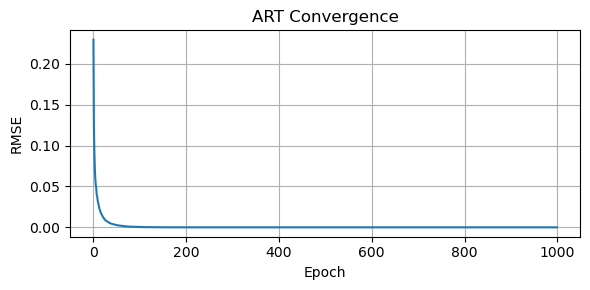

In [168]:
# reshape back to image
mu_img = mu_vec.reshape(grid_shape)#.transpose()

# plot rmse during optimization
plt.figure(figsize=(6,3))
plt.plot(rmse_list, '-')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("ART Convergence")
plt.grid(True)
plt.tight_layout()
plt.show()

In [133]:
print("b_i min:", np.min(b_i))
print("b_i max:", np.max(b_i))
print("Any NaN or Inf in b_i:", np.any(~np.isfinite(b_i)))


b_i min: 0.0
b_i max: 1.0
Any NaN or Inf in b_i: False


Sanity check

In [169]:
pred = A.dot(mu_vec)
res = b_i.flatten() - pred
l2_error = np.linalg.norm(mu_true_vec - mu_vec)

print("RMSE:", np.sqrt(np.mean(res**2)), "  max|res|:", np.max(np.abs(res)))
print("Negatives in mu:", np.sum(mu_vec < 0))
print(f"mu_vec.shape: {mu_vec.shape}")
print("L2 norm of reconstruction error:", l2_error)

RMSE: 1.6577652132290237e-16   max|res|: 4.440892098500626e-16
Negatives in mu: 0
mu_vec.shape: (100,)
L2 norm of reconstruction error: 0.5517413639073689


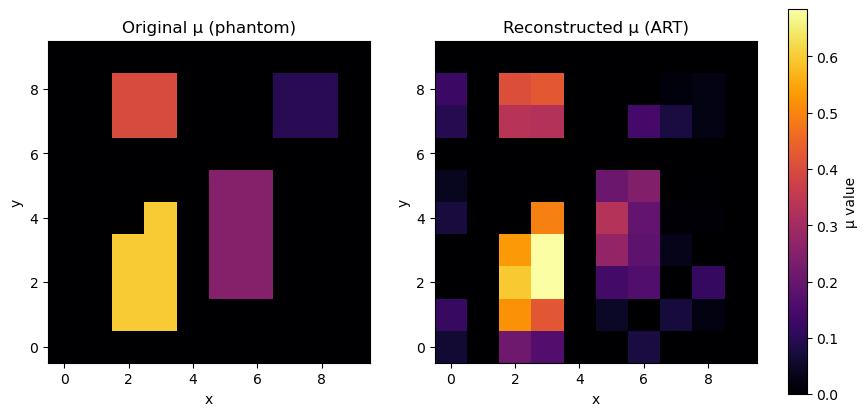

In [170]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mu_comparison(mu_true, mu_recon, grid_shape):
    """
    Display original and reconstructed μ images side by side.
    mu_true, mu_recon : flattened (M,) arrays
    grid_shape : (nx, ny) tuple used for reshaping
    """
    # reshape and orient correctly
    mu_true_img  = mu_true.reshape(grid_shape).T
    mu_recon_img = mu_recon.reshape(grid_shape).T

    vmin = min(mu_true_img.min(),  mu_recon_img.min())
    vmax = max(mu_true_img.max(),  mu_recon_img.max())

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for ax, img, title in zip(
        axs, [mu_true_img, mu_recon_img], ["Original μ (phantom)", "Reconstructed μ (ART)"]
    ):
        im = ax.imshow(img, cmap='inferno', origin='lower', vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04, label="μ value")
    #plt.tight_layout()
    plt.show()

# Assuming:
# - mu_true_vec : flattened true phantom (M,)
# - mu_recon    : ART result (M,)
# - grid_shape  : (nx, ny)

plot_mu_comparison(mu_true_vec, mu_vec, (grid_nx, grid_ny))
